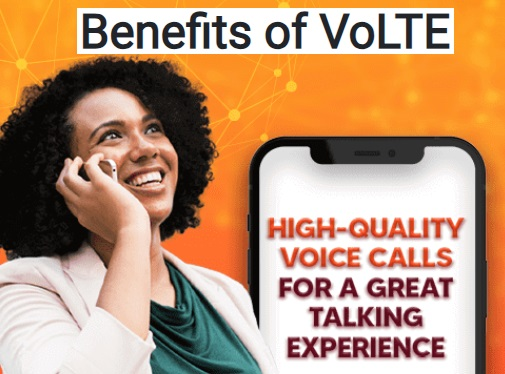

# Resumen proyecto DS

- Calcular el MOS (Media Opinion Score) voz en llamadas IP (VoLTE)
- Planteo de hipotesis previas (con el jitter, latencia, y packet Loss poder calcular el MOS)
- Remocion de valores atipicos
- Mediante regresion Lineal calcular los coeficientes
- Modelado
- Validacion del Modelo

# Rango de valores de MOS (Media Opinion Score)
indica la calidad de audio en una llamada VoIP
4.3 a 5 equivale a la calidad de audio de 2 personas hablando frente a frente en una habitacion silenciosa
un MOS de 3 equivale a una llamada de telfono fijo


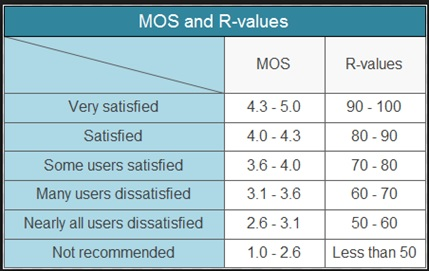

# Iportacion de librerías


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pylab import *
import plotly.express as px
from sklearn import linear_model
import statsmodels.api as sm
import seaborn as sns

# leer e DF de un par de CSV de guthub

In [2]:
df_orig = pd.concat(
    map(pd.read_csv, ['https://raw.githubusercontent.com/mlencina52/ciencia_datos/main/User_Plane_v5.csv',
                      'https://raw.githubusercontent.com/mlencina52/ciencia_datos/main/User_Plane_v6.csv',
                      'https://raw.githubusercontent.com/mlencina52/ciencia_datos/main/User_Plane_v7.csv',
                      'https://raw.githubusercontent.com/mlencina52/ciencia_datos/main/User_Plane_v8.csv',
                      'https://raw.githubusercontent.com/mlencina52/ciencia_datos/main/User_Plane_v10.csv',
                      'https://raw.githubusercontent.com/mlencina52/ciencia_datos/main/User_Plane_v11.csv']), ignore_index=True)

Cambio de nombre a la columna R-FACTOR para poderla graficar



#Eliminar columas innecesarias

In [3]:
df_orig = df_orig.drop(columns=['@timestamp', 'DEPARTAMENTO', 'HOSTNAME', 'TIMESTAMP','R-FACTOR_Count_Downlink_S1U'])
df_orig = df_orig.drop(columns=['LATITUD', 'LOCALIDAD', 'LONGITUD', 'PROVINCIA', '_id', '_index', '_type', 'highlight', 'location', 'sort', 'tags', 'type'])
df_orig = df_orig.drop(columns=['MOS_Count_Downlink_S1U', 'Count_Packet_Loss_Downlink_S1U', 'Count_Latency_Downlink_S1U', 'Count_Jitter_Downlink_S1U'])
df_orig = df_orig.drop(columns=['MOS_Count_Uplink_S1U', 'Count_Latency_Uplink_S1U', 'Count_PacketLoss_Uplink_S1U','Count_Jitter_Uplink_S1U','R-FACTOR_Count_Uplink_S1U'])

# ANALISIS DEL UPLINK S1U

In [4]:
df = df_orig.copy()
df = df[df['Average_Packet_Loss_Uplink_S1U'] <= 10.0]
df = df[df['Average_Latency_Uplink_S1U'] != 50.0]
df = df[df['Average_Latency_Uplink_S1U'] <= 70.0]
df = df[df['Average_Jitter_Uplink_S1U'] <= 80.0]
df = df[df['Average_One_Way_Audio_Uplink_S1U'] <= 150.0]

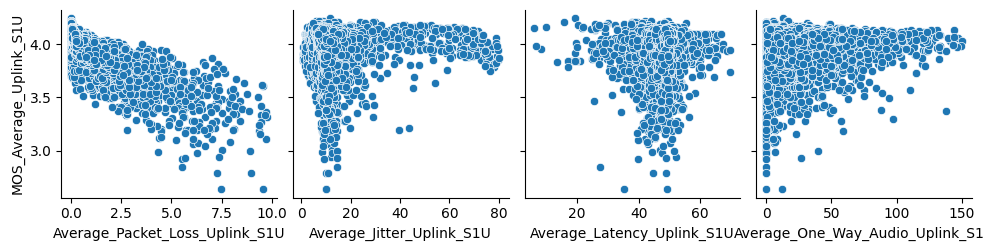

In [5]:
sns.pairplot(data=df,
            x_vars=["Average_Packet_Loss_Uplink_S1U","Average_Jitter_Uplink_S1U", "Average_Latency_Uplink_S1U", "Average_One_Way_Audio_Uplink_S1U"],
            y_vars=["MOS_Average_Uplink_S1U"]);

In [6]:
fig = px.scatter_3d(df, x='Average_Jitter_Uplink_S1U', y='Average_Packet_Loss_Uplink_S1U', z='MOS_Average_Uplink_S1U',color="MOS_Average_Uplink_S1U", color_continuous_scale=px.colors.sequential.RdBu)
fig.update_traces(marker_size = 4)
fig.show()

# Entrenamiento Modelo

# MODELO 1

## sklearn y statsmodels
https://datatofish.com/multiple-linear-regression-python/

SELECCIONAR VARIABLES

In [7]:
x = df[["Average_Packet_Loss_Uplink_S1U","Average_Jitter_Uplink_S1U","Average_Latency_Uplink_S1U","Average_One_Way_Audio_Uplink_S1U"]]
y = df["MOS_Average_Uplink_S1U"]

# Using sklearn

In [8]:
regression = linear_model.LinearRegression()
regression.fit(x, y)
predictions_sklearn = regression.predict(x)
print("Intercept: \n", regression.intercept_)
print("Coefficients: \n", regression.coef_)
print(regression.coef_[0],regression.coef_[1])

Intercept: 
 3.8897314238458116
Coefficients: 
 [-0.10018349 -0.0002239   0.00316911  0.00044837]
-0.10018349404732597 -0.00022390087462771484


# Using statsmodels

In [9]:
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions_statsmodels = model.predict(x)
summary = model.summary()
print(summary)

                              OLS Regression Results                              
Dep. Variable:     MOS_Average_Uplink_S1U   R-squared:                       0.655
Model:                                OLS   Adj. R-squared:                  0.655
Method:                     Least Squares   F-statistic:                     5903.
Date:                    Tue, 11 Jun 2024   Prob (F-statistic):               0.00
Time:                            15:29:16   Log-Likelihood:                 13686.
No. Observations:                   12431   AIC:                        -2.736e+04
Df Residuals:                       12426   BIC:                        -2.732e+04
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [10]:
x1 = "Average_Packet_Loss_Uplink_S1U"
x2 = "Average_Jitter_Uplink_S1U"
y = "MOS_Average_Uplink_S1U"

In [11]:
fig = px.scatter_3d(df, x=x1, y=x2, z=y,color=y, color_continuous_scale=px.colors.sequential.RdBu)
fig.update_traces(marker_size = 4)
light_yellow = [[0, '#FFDB58'], [1, '#FFDB58']]
xxx = np.linspace(df[x1].min(), df[x1].max(), num=10)
yyy = np.linspace(df[x2].min(), df[x2].max(), num=80)
X, Y = np.meshgrid(xxx, yyy)
Z1 = regression.intercept_ + regression.coef_[0] * X + regression.coef_[1] * Y
fig.add_trace(go.Surface(z=Z1, colorscale=light_yellow,showscale=False))
fig.show()

# ANALISIS DEL DOWNLINK S1U

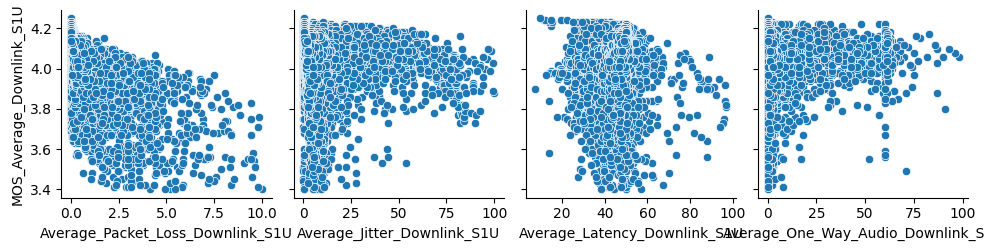

In [12]:
df = df_orig.copy()
df = df[df['Average_Packet_Loss_Downlink_S1U'] <= 10.0]
df = df[df['Average_Latency_Downlink_S1U'] <= 100.0]
df = df[df['Average_Jitter_Downlink_S1U'] <= 100.0]
df = df[df['Average_One_Way_Audio_Downlink_S1U'] <= 100.0]
df = df[df['MOS_Average_Downlink_S1U'] >= 3.4]
sns.pairplot(data=df,
            x_vars=["Average_Packet_Loss_Downlink_S1U","Average_Jitter_Downlink_S1U", "Average_Latency_Downlink_S1U", "Average_One_Way_Audio_Downlink_S1U"],
            y_vars=["MOS_Average_Downlink_S1U"]);

In [13]:
x = df[["Average_Packet_Loss_Downlink_S1U","Average_Jitter_Downlink_S1U","Average_Latency_Downlink_S1U","Average_One_Way_Audio_Downlink_S1U"]]
y = df["MOS_Average_Downlink_S1U"]

In [14]:
regression = linear_model.LinearRegression()
regression.fit(x, y)
predictions_sklearn = regression.predict(x)
print("Intercept: \n", regression.intercept_)
print("Coefficients: \n", regression.coef_)
print(regression.coef_[0],regression.coef_[1])

Intercept: 
 3.7967156475406654
Coefficients: 
 [-8.77044662e-02 -1.85328980e-03  6.73800568e-03  8.82567935e-05]
-0.08770446616032697 -0.0018532897971588688


In [15]:
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions_statsmodels = model.predict(x)
summary = model.summary()
print(summary)

                               OLS Regression Results                               
Dep. Variable:     MOS_Average_Downlink_S1U   R-squared:                       0.448
Model:                                  OLS   Adj. R-squared:                  0.448
Method:                       Least Squares   F-statistic:                 1.112e+04
Date:                      Tue, 11 Jun 2024   Prob (F-statistic):               0.00
Time:                              15:29:25   Log-Likelihood:                 70111.
No. Observations:                     54866   AIC:                        -1.402e+05
Df Residuals:                         54861   BIC:                        -1.402e+05
Df Model:                                 4                                         
Covariance Type:                  nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

Graficar los datos

In [16]:
x1 = "Average_Packet_Loss_Downlink_S1U"
x2 = "Average_Jitter_Downlink_S1U"
y = "MOS_Average_Downlink_S1U"

In [17]:
variables_x = [x1, x2]
variable_y = y
modelo = LinearRegression()
modelo.fit(df[variables_x], df[variable_y])
print ('Coeficientes: ', modelo.coef_)
print ('Intercepción: ', modelo.intercept_)

Coeficientes:  [-0.0889425  -0.00247854]
Intercepción:  4.119540088074942


In [18]:
fig = px.scatter_3d(df, x=x1, y=x2, z=y,color=y, color_continuous_scale=px.colors.sequential.RdBu)
fig.update_traces(marker_size = 4)
light_yellow = [[0, '#FFDB58'], [1, '#FFDB58']]
xxx = np.linspace(df[x1].min(), df[x1].max(), num=20)
yyy = np.linspace(df[x2].min(), df[x2].max(), num=100)
X, Y = np.meshgrid(xxx, yyy)
Z1 = modelo.intercept_ + modelo.coef_[0] * X + modelo.coef_[1] * Y
#Z1 = regression.intercept_ + regression.coef_[0] * X + regression.coef_[1] * Y
fig.add_trace(go.Surface(z=Z1, colorscale=light_yellow,showscale=False))
fig.show()

# ANALIZAR UPLINK Mb


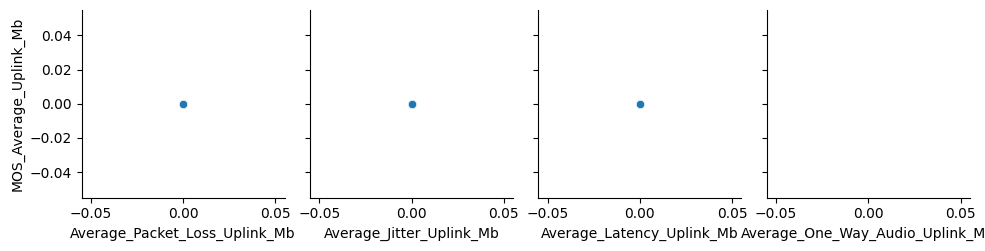

In [19]:
df = df_orig.copy()
#df = df[df['Average_Packet_Loss_Uplink_Mb'] <= 10.0]
#df = df[df['Average_Latency_Uplink_Mb'] != 50.0]
#df = df[df['Average_Latency_Uplink_Mb'] <= 70.0]
#df = df[df['Average_Jitter_Uplink_Mb'] <= 80.0]
#df = df[df['Average_One_Way_Audio_Uplink_Mb'] <= 150.0]

sns.pairplot(data=df,
            x_vars=["Average_Packet_Loss_Uplink_Mb","Average_Jitter_Uplink_Mb", "Average_Latency_Uplink_Mb", "Average_One_Way_Audio_Uplink_Mb"],
            y_vars=["MOS_Average_Uplink_Mb"]);

importar archivo con las geolocalicaciones


In [20]:
dfcells = pd.concat(map(pd.read_csv, ['https://raw.githubusercontent.com/mlencina52/ciencia_datos/main/CELL2.csv',
                      'https://raw.githubusercontent.com/mlencina52/ciencia_datos/main/Cells3.csv',
                      'https://raw.githubusercontent.com/mlencina52/ciencia_datos/main/Cells4.csv',
                      'https://raw.githubusercontent.com/mlencina52/ciencia_datos/main/User_Plane_v8.csv',
                      'https://raw.githubusercontent.com/mlencina52/ciencia_datos/main/User_Plane_v10.csv',
                      'https://raw.githubusercontent.com/mlencina52/ciencia_datos/main/User_Plane_v11.csv']), ignore_index=True)

In [21]:
dfcells = dfcells.drop(columns=['@timestamp', 'DEPARTAMENTO', 'HOSTNAME', 'TIMESTAMP', 'Average_Jitter_Downlink_Mb', 'Average_Jitter_Uplink_Mb','Average_Latency_Downlink_Mb','Average_Latency_Uplink_Mb','MOS_Average_Downlink_Mb','MOS_Average_Uplink_Mb','Average_One_Way_Audio_Downlink_Mb','Average_One_Way_Audio_Uplink_Mb','Average_Packet_Loss_Downlink_Mb','Average_Packet_Loss_Uplink_Mb','R-FACTOR_Count_Downlink_S1U'])
dfcells = dfcells.drop(columns=['LOCALIDAD', 'PROVINCIA', '_id', '_index', '_type', 'highlight', 'sort', 'tags', 'type'])
dfcells = dfcells.drop(columns=['MOS_Count_Downlink_S1U', 'Count_Packet_Loss_Downlink_S1U', 'Count_Latency_Downlink_S1U', 'Count_Jitter_Downlink_S1U','Average_One_Way_Audio_Downlink_S1U'])

In [22]:
dfcells = dfcells.drop(columns=['Average_Jitter_Downlink_S1U','Average_Latency_Downlink_S1U','Average_Packet_Loss_Downlink_S1U','Count_Jitter_Uplink_S1U'])

In [23]:
dfcells.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51431 entries, 0 to 51430
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Average_Jitter_Uplink_S1U         51431 non-null  float64
 1   Average_Latency_Uplink_S1U        51431 non-null  float64
 2   Average_One_Way_Audio_Uplink_S1U  51431 non-null  int64  
 3   Average_Packet_Loss_Uplink_S1U    51431 non-null  float64
 4   Count_Latency_Uplink_S1U          50336 non-null  float64
 5   Count_PacketLoss_Uplink_S1U       50336 non-null  float64
 6   LATITUD                           51431 non-null  float64
 7   LONGITUD                          51431 non-null  float64
 8   MOS_Average_Downlink_S1U          51431 non-null  float64
 9   MOS_Average_Uplink_S1U            51431 non-null  float64
 10  MOS_Count_Uplink_S1U              50336 non-null  float64
 11  R-FACTOR_Count_Uplink_S1U         50336 non-null  float64
 12  loca

In [24]:
dfcells

,Average_Jitter_Uplink_S1U,Average_Latency_Uplink_S1U,Average_One_Way_Audio_Uplink_S1U,Average_Packet_Loss_Uplink_S1U,Count_Latency_Uplink_S1U,Count_PacketLoss_Uplink_S1U,LATITUD,LONGITUD,MOS_Average_Downlink_S1U,MOS_Average_Uplink_S1U,MOS_Count_Uplink_S1U,R-FACTOR_Count_Uplink_S1U,location
0,22.20,50.0,50,0.49,125.0,125.0,-33.0,-60.7,4.13,4.00,125.0,125.0,"-32.99779,-60.65408299999999"
1,7.97,50.0,2,0.16,122.0,122.0,-33.0,-60.7,3.74,3.99,122.0,122.0,"-32.99779,-60.65408299999999"
2,9.25,50.0,26,0.54,143.0,143.0,-39.0,-68.1,4.00,4.05,143.0,143.0,"-38.965435,-68.06806800000001"
3,9.78,50.0,80,1.42,145.0,145.0,-39.0,-68.1,4.03,3.88,145.0,145.0,"-38.965435,-68.06806800000001"
4,11.10,50.0,24,0.56,133.0,133.0,-32.9,-68.9,4.12,4.06,133.0,133.0,"-32.933498,-68.85071500000001"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51426,11.50,50.3,25,0.23,150.0,150.0,-26.8,-65.2,4.09,4.03,150.0,150.0,"-26.829738,-65.206305"
51427,9.83,50.0,54,0.58,130.0,130.0,-26.8,-65.2,4.09,3.96,130.0,130.0,"-26.829738,-65.206305"
51428,10.40,50.0,61,0.59,136.0,136.0,-26.8,-65.2,4.13,3.98,136.0,136.0,"-26.829738,-65.206305"
51429,11.00,50.0,26,0.82,142.0,142.0,-26.8,-65.2,4.14,4.02,142.0,142.0,"-26.829738,-65.206305"


In [25]:
dfcells['MOScalc'] = dfcells['Average_Packet_Loss_Uplink_S1U'] * -0.1 + 3.89
dfcells

,Average_Jitter_Uplink_S1U,Average_Latency_Uplink_S1U,Average_One_Way_Audio_Uplink_S1U,Average_Packet_Loss_Uplink_S1U,Count_Latency_Uplink_S1U,Count_PacketLoss_Uplink_S1U,LATITUD,LONGITUD,MOS_Average_Downlink_S1U,MOS_Average_Uplink_S1U,MOS_Count_Uplink_S1U,R-FACTOR_Count_Uplink_S1U,location,MOScalc
0,22.20,50.0,50,0.49,125.0,125.0,-33.0,-60.7,4.13,4.00,125.0,125.0,"-32.99779,-60.65408299999999",3.841
1,7.97,50.0,2,0.16,122.0,122.0,-33.0,-60.7,3.74,3.99,122.0,122.0,"-32.99779,-60.65408299999999",3.874
2,9.25,50.0,26,0.54,143.0,143.0,-39.0,-68.1,4.00,4.05,143.0,143.0,"-38.965435,-68.06806800000001",3.836
3,9.78,50.0,80,1.42,145.0,145.0,-39.0,-68.1,4.03,3.88,145.0,145.0,"-38.965435,-68.06806800000001",3.748
4,11.10,50.0,24,0.56,133.0,133.0,-32.9,-68.9,4.12,4.06,133.0,133.0,"-32.933498,-68.85071500000001",3.834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51426,11.50,50.3,25,0.23,150.0,150.0,-26.8,-65.2,4.09,4.03,150.0,150.0,"-26.829738,-65.206305",3.867
51427,9.83,50.0,54,0.58,130.0,130.0,-26.8,-65.2,4.09,3.96,130.0,130.0,"-26.829738,-65.206305",3.832
51428,10.40,50.0,61,0.59,136.0,136.0,-26.8,-65.2,4.13,3.98,136.0,136.0,"-26.829738,-65.206305",3.831
51429,11.00,50.0,26,0.82,142.0,142.0,-26.8,-65.2,4.14,4.02,142.0,142.0,"-26.829738,-65.206305",3.808


# Generar mapa con el MOS

In [26]:
import ast
dfcells['location'] = dfcells['location'].apply(ast.literal_eval)
#dfcells['location'].str[0]
dfcells['lat'] = dfcells['location'].str[0]
dfcells['long'] = dfcells['location'].str[1]

In [27]:
fig = px.scatter_mapbox(dfcells, lat="lat", lon="long", zoom=3, height=600,color="MOScalc",color_continuous_scale=[(0, "red"), (0.9, "yellow"), (1.0, "blue")])
fig.update_layout(mapbox_style="carto-positron")
fig.show()